# 9章

In [1]:
ROLES = {
    "1": {
        "name": "一般知識エキスパート",
        "description": "幅広い分野の一般的な質問に答える",
        "details": "幅広い分野の一般的な質問に対して、正確で分かりやすい回答を提供してください。",
    },
    "2": {
        "name": "生成AI製品エキスパート",
        "description": "生成AIや関連製品、技術に関する専門的な質問に答える",
        "details": "生成AIや関連製品、技術に関する専門的な質問に対して、最新の情報と深い洞察を提供してください。",
    },
    "3": {
        "name": "カウンセラー",
        "description": "個人的な悩みや心理的な問題に対してサポートを提供する",
        "details": "個人的な悩みや心理的な問題に対して、共感的で支援的な回答を提供し、可能であれば適切なアドバイスも行ってください。",
    },
}


In [2]:
import operator
from typing import Annotated

from pydantic import BaseModel, Field


class State(BaseModel):
    query: str = Field(..., description="ユーザーからの質問")
    current_role: str = Field(default="", description="選定された回答ロール")
    messages: Annotated[list[str], operator.add] = Field(
        default=[], description="回答履歴"
    )
    current_judge: bool = Field(default=False, description="品質チェックの結果")
    judgement_reason: str = Field(default="", description="品質チェックの判定理由")


In [3]:
from langchain_openai import ChatOpenAI
from langchain_core.runnables import ConfigurableField

llm = ChatOpenAI(model="gpt-4o", temperature=0.0)
# 後からmax_tokensの値を変更できるように、変更可能なフィールドを宣言
llm = llm.configurable_fields(max_tokens=ConfigurableField(id="max_tokens"))


In [4]:
from typing import Any

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


def selection_node(state: State) -> dict[str, Any]:
    query = state.query
    role_options = "\n".join(
        [f"{k}. {v['name']}: {v['description']}" for k, v in ROLES.items()]
    )
    prompt = ChatPromptTemplate.from_template(
        """質問を分析し、最も適切な回答担当ロールを選択してください。

選択肢:
{role_options}

回答は選択肢の番号（1、2、または3）のみを返してください。

質問: {query}
""".strip()
    )
    # 選択肢の番号のみを返すことを期待したいため、max_tokensの値を1に変更
    chain = (
        prompt | llm.with_config(configurable=dict(max_tokens=1)) | StrOutputParser()
    )
    role_number = chain.invoke({"role_options": role_options, "query": query})

    selected_role = ROLES[role_number.strip()]["name"]
    return {"current_role": selected_role}


In [5]:
def answering_node(state: State) -> dict[str, Any]:
    query = state.query
    role = state.current_role
    role_details = "\n".join([f"- {v['name']}: {v['details']}" for v in ROLES.values()])
    prompt = ChatPromptTemplate.from_template(
        """あなたは{role}として回答してください。以下の質問に対して、あなたの役割に基づいた適切な回答を提供してください。

役割の詳細:
{role_details}

質問: {query}

回答:""".strip()
    )
    chain = prompt | llm | StrOutputParser()
    answer = chain.invoke({"role": role, "role_details": role_details, "query": query})
    return {"messages": [answer]}

In [6]:
class Judgement(BaseModel):
    judge: bool = Field(default=False, description="判定結果")
    reason: str = Field(default="", description="判定理由")


def check_node(state: State) -> dict[str, Any]:
    query = state.query
    answer = state.messages[-1]
    prompt = ChatPromptTemplate.from_template(
        """以下の回答の品質をチェックし、問題がある場合は'False'、問題がない場合は'True'を回答してください。
また、その判断理由も説明してください。

ユーザーからの質問: {query}
回答: {answer}
""".strip()
    )
    chain = prompt | llm.with_structured_output(Judgement)
    result: Judgement = chain.invoke({"query": query, "answer": answer})

    return {"current_judge": result.judge, "judgement_reason": result.reason}

In [7]:
from langgraph.graph import StateGraph

workflow = StateGraph(State)

In [8]:
workflow.add_node("selection", selection_node)
workflow.add_node("answering", answering_node)
workflow.add_node("check", check_node)

In [9]:
# selectionノードから処理を開始
workflow.set_entry_point("selection")
# selectionノードからansweringノードへ
workflow.add_edge("selection", "answering")
# answeringノードからcheckノードへ
workflow.add_edge("answering", "check")

In [10]:
from langgraph.graph import END

# checkノードから次のノードへの遷移に条件付きエッジを定義
# state.current_judgeの値がTrueならENDノードへ、Falseならselectionノードへ
workflow.add_conditional_edges(
    "check", lambda state: state.current_judge, {True: END, False: "selection"}
)

In [11]:
compiled = workflow.compile()

In [12]:
initial_state = State(query="生成AIについて教えてください")
result = compiled.invoke(initial_state)


In [13]:
result

{'query': '生成AIについて教えてください',
 'current_role': '生成AI製品エキスパート',
 'messages': ['生成AI製品エキスパートとしてお答えします。\n\n生成AI（生成的人工知能）は、データから新しいコンテンツを生成する能力を持つAI技術の一種です。これには、テキスト、画像、音声、音楽、ビデオなど、さまざまな形式のコンテンツが含まれます。生成AIの代表的な技術には、自然言語処理（NLP）を用いたテキスト生成モデルや、画像生成を行うGAN（生成的敵対ネットワーク）などがあります。\n\n生成AIの応用例としては、以下のようなものがあります：\n\n1. **テキスト生成**: 自然言語処理技術を用いて、文章の自動生成や要約、翻訳を行います。例えば、OpenAIのGPTシリーズは、非常に高品質なテキスト生成が可能です。\n\n2. **画像生成**: GANを用いて、新しい画像を生成します。これにより、アート作品の創作や、写真のスタイル変換、顔の合成などが可能です。\n\n3. **音楽生成**: AIが音楽を作曲することも可能で、特定のスタイルやジャンルに基づいた新しい楽曲を生成します。\n\n4. **音声合成**: テキストを音声に変換する技術で、自然な音声での読み上げが可能です。これにより、音声アシスタントやナレーションの自動生成が行われます。\n\n生成AIは、クリエイティブなプロセスを支援し、新しいアイデアやコンテンツを生み出すための強力なツールとして、さまざまな分野で活用されています。しかし、倫理的な問題や著作権の問題も伴うため、適切な利用が求められます。'],
 'current_judge': True,
 'judgement_reason': 'この回答は、生成AIについての基本的な情報を網羅的に提供しており、ユーザーの質問に対して適切に答えています。以下の点で品質が高いと判断できます。\n\n1. **明確な定義**: 生成AIの定義が明確に示されており、どのような形式のコンテンツを生成できるかが具体的に説明されています。\n\n2. **技術の例示**: 生成AIの代表的な技術として、自然言語処理やGANが挙げられており、技術的な背景が理解しやすくなっています。\n\n3. **応用例の提示*

In [14]:
print(result["messages"][-1])

生成AI製品エキスパートとしてお答えします。

生成AI（生成的人工知能）は、データから新しいコンテンツを生成する能力を持つAI技術の一種です。これには、テキスト、画像、音声、音楽、ビデオなど、さまざまな形式のコンテンツが含まれます。生成AIの代表的な技術には、自然言語処理（NLP）を用いたテキスト生成モデルや、画像生成を行うGAN（生成的敵対ネットワーク）などがあります。

生成AIの応用例としては、以下のようなものがあります：

1. **テキスト生成**: 自然言語処理技術を用いて、文章の自動生成や要約、翻訳を行います。例えば、OpenAIのGPTシリーズは、非常に高品質なテキスト生成が可能です。

2. **画像生成**: GANを用いて、新しい画像を生成します。これにより、アート作品の創作や、写真のスタイル変換、顔の合成などが可能です。

3. **音楽生成**: AIが音楽を作曲することも可能で、特定のスタイルやジャンルに基づいた新しい楽曲を生成します。

4. **音声合成**: テキストを音声に変換する技術で、自然な音声での読み上げが可能です。これにより、音声アシスタントやナレーションの自動生成が行われます。

生成AIは、クリエイティブなプロセスを支援し、新しいアイデアやコンテンツを生み出すための強力なツールとして、さまざまな分野で活用されています。しかし、倫理的な問題や著作権の問題も伴うため、適切な利用が求められます。


In [15]:
initial_state = State(query="生成AIについて教えてください")
result = await compiled.ainvoke(initial_state)  # 非同期
result


{'query': '生成AIについて教えてください',
 'current_role': '生成AI製品エキスパート',
 'messages': ['生成AI製品エキスパートとしてお答えします。\n\n生成AI（生成的人工知能）は、データから新しいコンテンツを生成する能力を持つAI技術の一分野です。これには、テキスト、画像、音声、動画などの多様な形式のコンテンツが含まれます。生成AIの代表的な技術には、GPT（Generative Pre-trained Transformer）やGAN（Generative Adversarial Network）などがあります。\n\nGPTは、特に自然言語処理において強力なモデルであり、人間のようなテキストを生成する能力があります。これにより、チャットボット、文章生成、翻訳、要約などのアプリケーションで広く利用されています。\n\n一方、GANは、二つのニューラルネットワーク（生成者と識別者）が競い合うことで、非常にリアルな画像や動画を生成することができます。これにより、画像の生成や修正、スタイル変換などの分野で活用されています。\n\n生成AIは、クリエイティブなプロセスを支援し、効率を向上させる一方で、倫理的な問題や誤用のリスクも伴います。例えば、フェイクニュースの生成や著作権の侵害などが懸念されています。そのため、生成AIの開発と利用には、倫理的な配慮と責任が求められます。\n\nこの分野は急速に進化しており、今後も新しい技術や応用が登場することが期待されています。'],
 'current_judge': True,
 'judgement_reason': 'この回答は、生成AIについての基本的な情報を網羅的に説明しており、特に問題は見当たりません。以下の点で評価できます。\n\n1. **定義の明確さ**: 生成AIの定義が明確に示されており、どのような形式のコンテンツを生成できるかが具体的に説明されています。\n\n2. **技術の紹介**: GPTとGANという代表的な技術が紹介され、それぞれの特徴と応用例が具体的に述べられています。\n\n3. **倫理的配慮**: 生成AIの利点だけでなく、倫理的な問題や誤用のリスクについても言及されており、バランスの取れた視点が提供されています。\n\n4. **将来

In [16]:
initial_state = State(query="生成AIについて教えてください")
for step in compiled.stream(initial_state):  # 逐次取得
    print(step)

{'selection': {'current_role': '生成AI製品エキスパート'}}
{'answering': {'messages': ['生成AI製品エキスパートとしてお答えします。\n\n生成AI（生成的人工知能）は、データから新しいコンテンツを生成する能力を持つAI技術の一分野です。これには、テキスト、画像、音声、動画などの生成が含まれます。生成AIの代表的な技術には、以下のようなものがあります。\n\n1. **GPT（Generative Pre-trained Transformer）**: これは、OpenAIが開発した自然言語処理モデルで、大量のテキストデータを基にして人間のような文章を生成することができます。GPT-3やGPT-4などのバージョンがあり、さまざまなアプリケーションで利用されています。\n\n2. **GAN（Generative Adversarial Networks）**: これは、2つのニューラルネットワーク（生成者と識別者）が競い合うことで、リアルなデータを生成する技術です。特に画像生成の分野で多く利用されており、写真のようなリアルな画像を生成することが可能です。\n\n3. **VAE（Variational Autoencoders）**: これは、データの潜在的な特徴を学習し、新しいデータを生成するためのモデルです。主に画像や音声の生成に使われます。\n\n生成AIは、クリエイティブなコンテンツの制作、自動化されたカスタマーサービス、医療診断の支援、教育コンテンツの生成など、さまざまな分野で応用されています。しかし、生成AIの利用には倫理的な課題も伴い、フェイクニュースの生成やプライバシーの侵害といった問題に対する対策が求められています。\n\nこの分野は急速に進化しており、今後も新しい技術や応用が登場することが期待されています。']}}
{'check': {'current_judge': True, 'judgement_reason': 'この回答は、生成AIについての基本的な情報を網羅的に提供しており、ユーザーの質問に対して適切に応答しています。以下の点で品質が高いと判断できます。\n\n1. **明確な定義**: 生成AIの定義が明確に示されており、どのようなコンテンツを生成できるかが具体的に

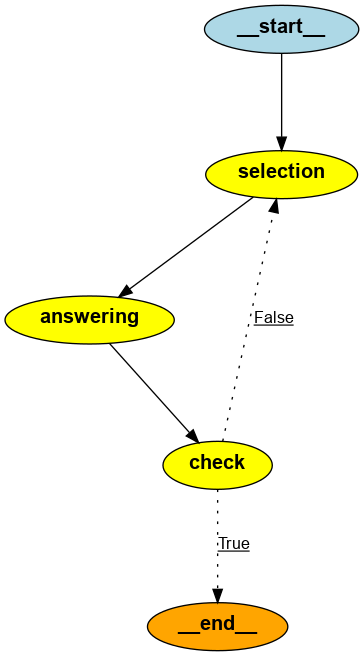

In [17]:
from IPython.display import Image

Image(compiled.get_graph().draw_png())

## 9.4

In [18]:
import operator
from typing import Annotated, Any
from langchain_core.messages import SystemMessage, HumanMessage, BaseMessage
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field


# グラフのステートを定義
class State(BaseModel):
    query: str
    messages: Annotated[list[BaseMessage], operator.add] = Field(default=[])


# メッセージを追加するノード関数
def add_message(state: State) -> dict[str, Any]:
    additional_messages = []
    if not state.messages:
        additional_messages.append(
            SystemMessage(content="あなたは最小限の応答をする対話エージェントです。")
        )
    additional_messages.append(HumanMessage(content=state.query))
    return {"messages": additional_messages}


# LLMからの応答を追加するノード関数
def llm_response(state: State) -> dict[str, Any]:
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)
    ai_message = llm.invoke(state.messages)
    return {"messages": [ai_message]}


In [19]:
from pprint import pprint
from langchain_core.runnables import RunnableConfig
from langgraph.checkpoint.base import BaseCheckpointSaver


def print_checkpoint_dump(checkpointer: BaseCheckpointSaver, config: RunnableConfig):
    checkpoint_tuple = checkpointer.get_tuple(config)

    print("チェックポイントデータ:")
    pprint(checkpoint_tuple.checkpoint)
    print("\nメタデータ:")
    pprint(checkpoint_tuple.metadata)


In [20]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

# グラフを設定
graph = StateGraph(State)
graph.add_node("add_message", add_message)
graph.add_node("llm_response", llm_response)

graph.set_entry_point("add_message")
graph.add_edge("add_message", "llm_response")
graph.add_edge("llm_response", END)

# チェックポインターを設定
checkpointer = MemorySaver()

# グラフをコンパイル
compiled_graph = graph.compile(checkpointer=checkpointer)


In [21]:
config = {"configurable": {"thread_id": "example-1"}}
user_query = State(query="私の好きなものはずんだ餅です。覚えておいてね。")
first_response = compiled_graph.invoke(user_query, config)
first_response


{'query': '私の好きなものはずんだ餅です。覚えておいてね。',
 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
  AIMessage(content='了解しました。ずんだ餅ですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 48, 'total_tokens': 58, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CSyXNJczluijk7uFOq90q4sfj3SCf', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--0e8dae4c-13e2-4eea-9b01-91f4099af0f6-0', usage_metadata={'input_tokens': 48, 'output_tokens': 10, 'total_tokens': 58, 'input_token_details

In [22]:
for checkpoint in checkpointer.list(config):
    print(checkpoint)


CheckpointTuple(config={'configurable': {'thread_id': 'example-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ae38c-31fc-6f5a-8002-e00c8fddce2c'}}, checkpoint={'v': 4, 'ts': '2025-10-21T04:45:26.352869+00:00', 'id': '1f0ae38c-31fc-6f5a-8002-e00c8fddce2c', 'channel_versions': {'__start__': '00000000000000000000000000000002.0.727057819971006', 'query': '00000000000000000000000000000002.0.727057819971006', 'messages': '00000000000000000000000000000004.0.46338861210284155', 'branch:to:add_message': '00000000000000000000000000000003.0.3172903045008276', 'branch:to:llm_response': '00000000000000000000000000000004.0.46338861210284155'}, 'versions_seen': {'__input__': {}, '__start__': {'__start__': '00000000000000000000000000000001.0.8070223456706067'}, 'add_message': {'branch:to:add_message': '00000000000000000000000000000002.0.727057819971006'}, 'llm_response': {'branch:to:llm_response': '00000000000000000000000000000003.0.3172903045008276'}}, 'updated_channels': ['messages'], 'channel_values

In [23]:
print_checkpoint_dump(checkpointer, config)


チェックポイントデータ:
{'channel_values': {'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
                                 HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
                                 AIMessage(content='了解しました。ずんだ餅ですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 48, 'total_tokens': 58, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CSyXNJczluijk7uFOq90q4sfj3SCf', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--0e8dae4c-13e2-4eea-9b01-91f4099af0f6-0', usage_metadata={'input_tokens': 48, 'out

In [24]:
user_query = State(query="私の好物は何か覚えてる？")
second_response = compiled_graph.invoke(user_query, config)
second_response


{'query': '私の好物は何か覚えてる？',
 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
  AIMessage(content='了解しました。ずんだ餅ですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 48, 'total_tokens': 58, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CSyXNJczluijk7uFOq90q4sfj3SCf', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--0e8dae4c-13e2-4eea-9b01-91f4099af0f6-0', usage_metadata={'input_tokens': 48, 'output_tokens': 10, 'total_tokens': 58, 'input_token_details': {'audio'

In [25]:
for checkpoint in checkpointer.list(config):
    print(checkpoint)


CheckpointTuple(config={'configurable': {'thread_id': 'example-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ae390-542a-6227-8006-04fae8a3525d'}}, checkpoint={'v': 4, 'ts': '2025-10-21T04:47:17.310717+00:00', 'id': '1f0ae390-542a-6227-8006-04fae8a3525d', 'channel_versions': {'__start__': '00000000000000000000000000000006.0.5889802787668253', 'query': '00000000000000000000000000000006.0.5889802787668253', 'messages': '00000000000000000000000000000008.0.4869882870148683', 'branch:to:add_message': '00000000000000000000000000000007.0.5735187487975623', 'branch:to:llm_response': '00000000000000000000000000000008.0.4869882870148683'}, 'versions_seen': {'__input__': {}, '__start__': {'__start__': '00000000000000000000000000000005.0.8275567833540522'}, 'add_message': {'branch:to:add_message': '00000000000000000000000000000006.0.5889802787668253'}, 'llm_response': {'branch:to:llm_response': '00000000000000000000000000000007.0.5735187487975623'}}, 'updated_channels': ['messages'], 'channel_value

In [26]:
print_checkpoint_dump(checkpointer, config)


チェックポイントデータ:
{'channel_values': {'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
                                 HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
                                 AIMessage(content='了解しました。ずんだ餅ですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 48, 'total_tokens': 58, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CSyXNJczluijk7uFOq90q4sfj3SCf', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--0e8dae4c-13e2-4eea-9b01-91f4099af0f6-0', usage_metadata={'input_tokens': 48, 'out

別IDから

In [27]:
config = {"configurable": {"thread_id": "example-2"}}
user_query = State(query="私の好物は何？")
other_thread_response = compiled_graph.invoke(user_query, config)
other_thread_response


{'query': '私の好物は何？',
 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私の好物は何？', additional_kwargs={}, response_metadata={}),
  AIMessage(content='わかりません。あなたの好物は何ですか？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 36, 'total_tokens': 50, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CSyeogOXabDN60F7BAktJ6AeqSyVL', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--0d56a397-0d93-4bf4-95e7-8347dfd9b16d-0', usage_metadata={'input_tokens': 36, 'output_tokens': 14, 'total_tokens': 50, 'input_token_details': {'audio': 0, 'cache_read'